In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, ExtraTreesClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import lightgbm as lgb
import catboost as cb
import xgboost as xgb

## Manipulation

In [2]:
df = pd.read_csv('/workspaces/NN_lec/raw_data/matches.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4788 entries, 0 to 4787
Data columns (total 28 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Unnamed: 0    4788 non-null   int64  
 1   date          4788 non-null   object 
 2   time          4788 non-null   object 
 3   comp          4788 non-null   object 
 4   round         4788 non-null   object 
 5   day           4788 non-null   object 
 6   venue         4788 non-null   object 
 7   result        4788 non-null   object 
 8   gf            4788 non-null   int64  
 9   ga            4788 non-null   int64  
 10  opponent      4788 non-null   object 
 11  xg            4788 non-null   float64
 12  xga           4788 non-null   float64
 13  poss          4788 non-null   int64  
 14  attendance    3155 non-null   float64
 15  captain       4788 non-null   object 
 16  formation     4788 non-null   object 
 17  referee       4788 non-null   object 
 18  match report  4788 non-null 

In [4]:
df.head()

,Unnamed: 0,date,time,comp,round,day,venue,result,gf,ga,opponent,xg,xga,poss,attendance,captain,formation,referee,match report,notes,sh,sot,dist,fk,pk,pkatt,season,team
0,0,2020-09-21,20:15 (21:15),Premier League,Matchweek 2,Mon,Away,W,3,1,Wolves,1.9,0.6,65,NaN,Fernandinho,4-2-3-1,Andre Marriner,Match Report,NaN,13,8,21.1,2,1,1,2024,Manchester City
1,2,2020-09-27,16:30 (17:30),Premier League,Matchweek 3,Sun,Home,L,2,5,Leicester City,0.9,2.9,72,NaN,Fernandinho,4-2-3-1,Michael Oliver,Match Report,NaN,16,5,19.8,1,0,0,2024,Manchester City
2,4,2020-10-03,17:30 (18:30),Premier League,Matchweek 4,Sat,Away,D,1,1,Leeds United,1.2,2.4,49,NaN,Kevin De Bruyne,4-3-3,Mike Dean,Match Report,NaN,23,1,18.2,1,0,0,2024,Manchester City
3,5,2020-10-17,17:30 (18:30),Premier League,Matchweek 5,Sat,Home,W,1,0,Arsenal,1.3,0.9,58,NaN,Raheem Sterling,3-1-4-2,Chris Kavanagh,Match Report,NaN,13,5,17.7,0,0,0,2024,Manchester City
4,7,2020-10-24,12:30 (13:30),Premier League,Matchweek 6,Sat,Away,D,1,1,West Ham,1.0,0.3,69,NaN,Raheem Sterling,4-3-3,Anthony Taylor,Match Report,NaN,14,7,20.9,1,0,0,2024,Manchester City


In [5]:
df.drop(columns=["Unnamed: 0", "comp", "round", "attendance", "match report", "notes"], inplace=True)

In [6]:
df.describe()

,gf,ga,xg,xga,poss,sh,sot,dist,fk,pk,pkatt,season
count,4788.000000,4788.000000,4788.000000,4788.000000,4788.000000,4788.000000,4788.000000,4786.000000,4788.000000,4788.000000,4788.00000,4788.000000
mean,1.447995,1.405388,1.396512,1.364745,50.432957,12.619256,4.261278,17.356247,0.453216,0.118212,0.14599,2022.365079
std,1.312635,1.286927,0.828847,0.814947,12.810958,5.548444,2.459963,3.049341,0.665250,0.342362,0.37937,1.461850
min,0.000000,0.000000,0.000000,0.000000,18.000000,0.000000,0.000000,5.300000,0.000000,0.000000,0.00000,2020.000000
25%,0.000000,0.000000,0.800000,0.700000,41.000000,9.000000,2.000000,15.400000,0.000000,0.000000,0.00000,2021.000000
50%,1.000000,1.000000,1.300000,1.200000,51.000000,12.000000,4.000000,17.200000,0.000000,0.000000,0.00000,2023.000000
75%,2.000000,2.000000,1.900000,1.800000,60.000000,16.000000,6.000000,19.100000,1.000000,0.000000,0.00000,2024.000000
max,9.000000,9.000000,7.000000,7.000000,82.000000,36.000000,15.000000,39.900000,4.000000,3.000000,3.00000,2024.000000


In [7]:
df.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team
0,2020-09-21,20:15 (21:15),Mon,Away,W,3,1,Wolves,1.9,0.6,65,Fernandinho,4-2-3-1,Andre Marriner,13,8,21.1,2,1,1,2024,Manchester City
1,2020-09-27,16:30 (17:30),Sun,Home,L,2,5,Leicester City,0.9,2.9,72,Fernandinho,4-2-3-1,Michael Oliver,16,5,19.8,1,0,0,2024,Manchester City
2,2020-10-03,17:30 (18:30),Sat,Away,D,1,1,Leeds United,1.2,2.4,49,Kevin De Bruyne,4-3-3,Mike Dean,23,1,18.2,1,0,0,2024,Manchester City
3,2020-10-17,17:30 (18:30),Sat,Home,W,1,0,Arsenal,1.3,0.9,58,Raheem Sterling,3-1-4-2,Chris Kavanagh,13,5,17.7,0,0,0,2024,Manchester City
4,2020-10-24,12:30 (13:30),Sat,Away,D,1,1,West Ham,1.0,0.3,69,Raheem Sterling,4-3-3,Anthony Taylor,14,7,20.9,1,0,0,2024,Manchester City


In [8]:
df.dtypes

date          object
time          object
day           object
venue         object
result        object
gf             int64
ga             int64
opponent      object
xg           float64
xga          float64
poss           int64
captain       object
formation     object
referee       object
sh             int64
sot            int64
dist         float64
fk             int64
pk             int64
pkatt          int64
season         int64
team          object
dtype: object

In [9]:
df['date'] = pd.to_datetime(df['date'])

In [10]:
df['venue'] = df['venue'].astype('category')
df['opponent'] = df['opponent'].astype('category')
df['team'] = df['team'].astype('category')
df['result'] = df['result'].astype('category')
df['day'] = df['date'].dt.day_name()

In [11]:
df["hour"] = df["time"].str.replace(":.+", "", regex=True).astype("int")

In [12]:
df["day_code"] = df["date"].dt.dayofweek

In [13]:
df.duplicated().sum()

0

In [14]:
df.dropna(inplace=True)

In [15]:
df.formation.value_counts()

formation
4-2-3-1       1382
4-3-3         1025
4-4-2          581
3-4-3          548
3-5-2          266
4-1-4-1        258
4-4-1-1        141
3-4-1-2        113
5-3-2          107
5-4-1           99
4-5-1           49
4-3-1-2         47
4-1-2-1-2◆      35
4-2-2-2         29
3-1-4-2         25
4-3-2-1         22
3-2-4-1         21
3-3-3-1         17
3-5-1-1         14
3-4-3◆           3
4-1-3-2          2
4-2-4-0          2
Name: count, dtype: int64

In [16]:
df.formation = df.formation.str.replace("◆", "")
df.formation = df.formation.str.replace("-0", "")

In [17]:
df.formation.value_counts()

formation
4-2-3-1      1382
4-3-3        1025
4-4-2         581
3-4-3         551
3-5-2         266
4-1-4-1       258
4-4-1-1       141
3-4-1-2       113
5-3-2         107
5-4-1          99
4-5-1          49
4-3-1-2        47
4-1-2-1-2      35
4-2-2-2        29
3-1-4-2        25
4-3-2-1        22
3-2-4-1        21
3-3-3-1        17
3-5-1-1        14
4-1-3-2         2
4-2-4           2
Name: count, dtype: int64

In [18]:
df['season'].value_counts()

season
2024    1519
2023     988
2022     760
2020     760
2021     759
Name: count, dtype: int64

In [19]:
df_cols = df.columns
df_cols = df_cols.drop('season')

df.duplicated(subset=df_cols).sum()

987

In [20]:
df.drop_duplicates(subset=df_cols, inplace=True)

In [21]:
df.duplicated(subset=df_cols).sum()

0

In [22]:
def correct_seasons(df):
    def get_correct_season(date):
        if isinstance(date, str):
            date = pd.to_datetime(date)
        if date.month >= 8:
            return date.year + 1
        else:
            return date.year

    df['season'] = df['date'].apply(get_correct_season)
    return df

In [23]:
df = correct_seasons(df)
df['season'].value_counts().sort_index()

season
2020    760
2021    759
2022    760
2023    760
2024    760
Name: count, dtype: int64

In [24]:
df['points'] = df['result'].apply(lambda x: 3 if x == 'W' else 1 if x == 'D' else 0)

In [25]:
df['points'] = df['points'].astype('int')

In [26]:
winners = df.groupby(['season', 'team'], observed=False)['points'].sum().reset_index() \
  .sort_values(['season', 'points'], ascending=[True, False]) \
  .groupby('season', observed=False).first()

In [27]:
winners

,team,points
season,,
2020,Liverpool,99
2021,Manchester City,86
2022,Manchester City,93
2023,Manchester City,89
2024,Manchester City,91


In [28]:
df['season_winner'] = df['season'].map(winners['team'])

In [29]:
df.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team,hour,day_code,points,season_winner
0,2020-09-21,20:15 (21:15),Monday,Away,W,3,1,Wolves,1.9,0.6,65,Fernandinho,4-2-3-1,Andre Marriner,13,8,21.1,2,1,1,2021,Manchester City,20,0,3,Manchester City
1,2020-09-27,16:30 (17:30),Sunday,Home,L,2,5,Leicester City,0.9,2.9,72,Fernandinho,4-2-3-1,Michael Oliver,16,5,19.8,1,0,0,2021,Manchester City,16,6,0,Manchester City
2,2020-10-03,17:30 (18:30),Saturday,Away,D,1,1,Leeds United,1.2,2.4,49,Kevin De Bruyne,4-3-3,Mike Dean,23,1,18.2,1,0,0,2021,Manchester City,17,5,1,Manchester City
3,2020-10-17,17:30 (18:30),Saturday,Home,W,1,0,Arsenal,1.3,0.9,58,Raheem Sterling,3-1-4-2,Chris Kavanagh,13,5,17.7,0,0,0,2021,Manchester City,17,5,3,Manchester City
4,2020-10-24,12:30 (13:30),Saturday,Away,D,1,1,West Ham,1.0,0.3,69,Raheem Sterling,4-3-3,Anthony Taylor,14,7,20.9,1,0,0,2021,Manchester City,12,5,1,Manchester City


In [30]:
df.shape

(3799, 26)

In [31]:
df['season'].value_counts()

season
2020    760
2024    760
2023    760
2022    760
2021    759
Name: count, dtype: int64

In [32]:
def captains_func(data):
    if data['count'] == 0:
        data['count'] = np.nan
    return data

In [33]:
group = df.groupby('team', observed=False)['captain'].value_counts().reset_index(name='count')
group = group.apply(captains_func, axis=1)
group.dropna(inplace=True)
group = group.drop(columns='count')
group

,team,captain
0,Arsenal,Martin Ødegaard
1,Arsenal,Pierre-Emerick Aubameyang
2,Arsenal,Alexandre Lacazette
3,Arsenal,Granit Xhaka
4,Arsenal,Héctor Bellerín
...,...,...
4450,Wolverhampton Wanderers,Conor Coady
4451,Wolverhampton Wanderers,Max Kilman
4452,Wolverhampton Wanderers,Rúben Neves
4453,Wolverhampton Wanderers,João Moutinho


In [34]:
group['team'].value_counts()

team
Chelsea                     12
Everton                     11
Arsenal                     10
Sheffield United             9
Crystal Palace               9
Tottenham Hotspur            8
Newcastle United             8
Manchester United            8
Manchester City              8
West Ham United              8
Watford                      8
Fulham                       7
Leicester City               7
Liverpool                    7
Aston Villa                  7
Brighton and Hove Albion     7
Nottingham Forest            7
Burnley                      6
Brentford                    6
Norwich City                 6
Bournemouth                  6
Wolverhampton Wanderers      5
Leeds United                 5
West Bromwich Albion         4
Luton Town                   4
Southampton                  3
Name: count, dtype: int64

In [35]:
group[group['team'] == 'Liverpool']

,team,captain
2136,Liverpool,Jordan Henderson
2137,Liverpool,Virgil van Dijk
2138,Liverpool,James Milner
2139,Liverpool,Georginio Wijnaldum
2140,Liverpool,Andrew Robertson
2141,Liverpool,Roberto Firmino
2142,Liverpool,Trent Alexander-Arnold


In [36]:
group.to_csv('captains.csv', index=False)

## Preprocessing

In [37]:
df.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team,hour,day_code,points,season_winner
0,2020-09-21,20:15 (21:15),Monday,Away,W,3,1,Wolves,1.9,0.6,65,Fernandinho,4-2-3-1,Andre Marriner,13,8,21.1,2,1,1,2021,Manchester City,20,0,3,Manchester City
1,2020-09-27,16:30 (17:30),Sunday,Home,L,2,5,Leicester City,0.9,2.9,72,Fernandinho,4-2-3-1,Michael Oliver,16,5,19.8,1,0,0,2021,Manchester City,16,6,0,Manchester City
2,2020-10-03,17:30 (18:30),Saturday,Away,D,1,1,Leeds United,1.2,2.4,49,Kevin De Bruyne,4-3-3,Mike Dean,23,1,18.2,1,0,0,2021,Manchester City,17,5,1,Manchester City
3,2020-10-17,17:30 (18:30),Saturday,Home,W,1,0,Arsenal,1.3,0.9,58,Raheem Sterling,3-1-4-2,Chris Kavanagh,13,5,17.7,0,0,0,2021,Manchester City,17,5,3,Manchester City
4,2020-10-24,12:30 (13:30),Saturday,Away,D,1,1,West Ham,1.0,0.3,69,Raheem Sterling,4-3-3,Anthony Taylor,14,7,20.9,1,0,0,2021,Manchester City,12,5,1,Manchester City


In [38]:
df.isna().sum()

date             0
time             0
day              0
venue            0
result           0
gf               0
ga               0
opponent         0
xg               0
xga              0
poss             0
captain          0
formation        0
referee          0
sh               0
sot              0
dist             0
fk               0
pk               0
pkatt            0
season           0
team             0
hour             0
day_code         0
points           0
season_winner    0
dtype: int64

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3799 entries, 0 to 4787
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           3799 non-null   datetime64[ns]
 1   time           3799 non-null   object        
 2   day            3799 non-null   object        
 3   venue          3799 non-null   category      
 4   result         3799 non-null   category      
 5   gf             3799 non-null   int64         
 6   ga             3799 non-null   int64         
 7   opponent       3799 non-null   category      
 8   xg             3799 non-null   float64       
 9   xga            3799 non-null   float64       
 10  poss           3799 non-null   int64         
 11  captain        3799 non-null   object        
 12  formation      3799 non-null   object        
 13  referee        3799 non-null   object        
 14  sh             3799 non-null   int64         
 15  sot            3799 non-nu

In [40]:
df.columns

Index(['date', 'time', 'day', 'venue', 'result', 'gf', 'ga', 'opponent', 'xg',
       'xga', 'poss', 'captain', 'formation', 'referee', 'sh', 'sot', 'dist',
       'fk', 'pk', 'pkatt', 'season', 'team', 'hour', 'day_code', 'points',
       'season_winner'],
      dtype='object')

In [41]:
df['date'] = pd.to_datetime(df['date'])

# Sort the DataFrame by team and date
df_sorted = df.sort_values(['team', 'date'])

# Reset the index to reflect the new order
df_sorted = df_sorted.reset_index(drop=True)

# Verify the sorting
def verify_sorting(data):
    # Check if dates are in ascending order for each team
    is_sorted = data.groupby('team', observed=False)['date'].is_monotonic_increasing.all()
    
    if is_sorted:
        print("Data is correctly sorted by date for each team.")
    else:
        print("WARNING: Data is not correctly sorted. Please check for inconsistencies.")

# Run the verification
verify_sorting(df_sorted)

Data is correctly sorted by date for each team.


In [42]:
num_cols = ['sh', 'sot', 'dist', 'fk', 'pk', 'pkatt', 'xga', 'xg', 'gf', 'ga']
for col in num_cols:
    df_sorted[col] = pd.to_numeric(df_sorted[col])

In [43]:
def calculate_fk_pk_ratios(data):
    """
    Calculate ratios and percentages for free kicks and penalties.
    
    Parameters:
    data (DataFrame): The input DataFrame containing 'fk', 'pk', 'pkatt', and 'sh' columns
    
    Returns:
    DataFrame: The input DataFrame with additional columns for FK and PK ratios
    """
    # Free Kick Ratio: Free Kicks / Total Shots
    data['fk_ratio'] = data['fk'] / data['sh']
    
    # Penalty Conversion Rate: Penalties Scored / Penalties Attempted
    data['pk_conversion_rate'] = data['pk'] / data['pkatt']
    
    # Penalties per Shot: Penalties Attempted / Total Shots
    data['pk_per_shot'] = data['pkatt'] / data['sh']
    
    # Handle division by zero
    data['fk_ratio'] = data['fk_ratio'].replace([np.inf, -np.inf], np.nan)
    data['pk_conversion_rate'] = data['pk_conversion_rate'].replace([np.inf, -np.inf], np.nan)
    data['pk_per_shot'] = data['pk_per_shot'].replace([np.inf, -np.inf], np.nan)
    
    # Convert to percentages
    data['fk_percentage'] = data['fk_ratio'] * 100
    data['pk_conversion_percentage'] = data['pk_conversion_rate'] * 100
    data['pk_per_shot_percentage'] = data['pk_per_shot'] * 100
    
    return data

In [44]:
df_sorted = calculate_fk_pk_ratios(df_sorted)

In [45]:
df_sorted.drop(['pk_conversion_rate', 'pk_conversion_percentage'], axis=1, inplace=True)

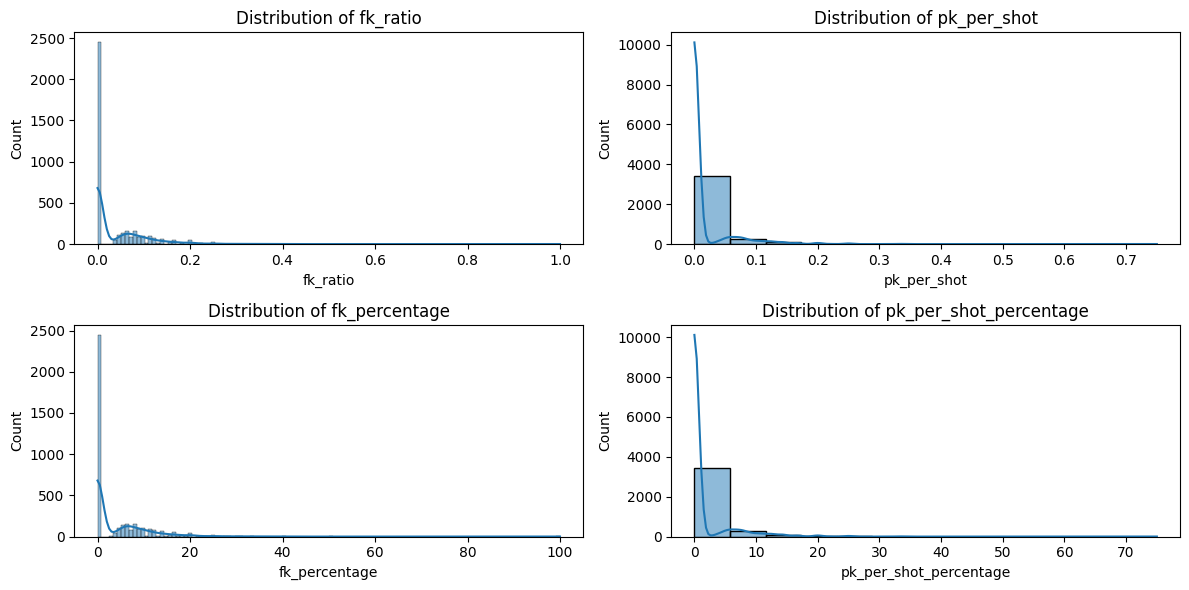

In [46]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
i = 0
for col in ['fk_ratio', 'pk_per_shot', 'fk_percentage', 'pk_per_shot_percentage']:
    sns.histplot(df_sorted[col], kde=True, ax=axs.flatten()[i])
    axs.flatten()[i].set_title('Distribution of ' + col)
    i += 1

plt.tight_layout()
plt.show()

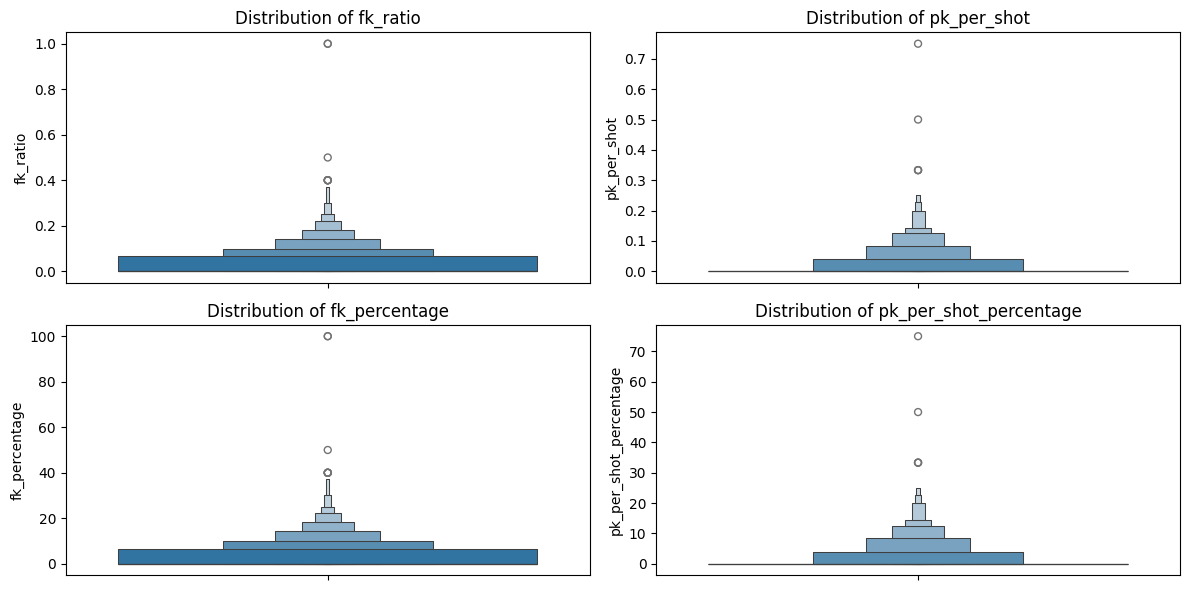

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(12, 6))
i = 0
for col in ['fk_ratio', 'pk_per_shot', 'fk_percentage', 'pk_per_shot_percentage']:
    sns.boxenplot(df_sorted[col], ax=axs.flatten()[i])
    axs.flatten()[i].set_title('Distribution of ' + col)
    i += 1

plt.tight_layout()
plt.show()

In [48]:
df_sorted.head()

,date,time,day,venue,result,gf,ga,opponent,xg,xga,poss,captain,formation,referee,sh,sot,dist,fk,pk,pkatt,season,team,hour,day_code,points,season_winner,fk_ratio,pk_per_shot,fk_percentage,pk_per_shot_percentage
0,2019-08-11,14:00 (15:00),Sunday,Away,W,1,0,Newcastle Utd,1.1,0.4,62,Granit Xhaka,4-2-3-1,Martin Atkinson,8,2,13.9,0,0,0,2020,Arsenal,14,6,3,Liverpool,0.000000,0.0,0.000000,0.0
1,2019-08-17,12:30 (13:30),Saturday,Home,W,2,1,Burnley,0.8,1.5,67,Nacho Monreal,4-2-3-1,Mike Dean,15,9,18.7,0,0,0,2020,Arsenal,12,5,3,Liverpool,0.000000,0.0,0.000000,0.0
2,2019-08-24,17:30 (18:30),Saturday,Away,L,1,3,Liverpool,1.0,2.5,48,Granit Xhaka,4-3-1-2,Anthony Taylor,9,3,19.0,1,0,0,2020,Arsenal,17,5,0,Liverpool,0.111111,0.0,11.111111,0.0
3,2019-09-01,16:30 (17:30),Sunday,Home,D,2,2,Tottenham,2.4,2.0,55,Granit Xhaka,4-3-3,Martin Atkinson,26,8,18.1,2,0,0,2020,Arsenal,16,6,1,Liverpool,0.076923,0.0,7.692308,0.0
4,2019-09-15,16:30 (17:30),Sunday,Away,D,2,2,Watford,0.8,2.7,48,Granit Xhaka,4-1-2-1-2,Anthony Taylor,7,4,20.8,0,0,0,2020,Arsenal,16,6,1,Liverpool,0.000000,0.0,0.000000,0.0


In [49]:
def calculate_rolling_average(data, column, window=5):
    """
    Calculate the rolling average of a column for each team.
    
    Parameters:
    data (DataFrame): The input DataFrame
    column (str): The column to calculate the rolling average for
    window (int): The number of games to include in the rolling average
    
    Returns:
    Series: The rolling average
    """
    return data.groupby('team', observed=False)[column].transform(
        lambda x: x.rolling(window=window, min_periods=1).mean()
    )

In [50]:
df_sorted['rolling_xg'] = calculate_rolling_average(df_sorted, 'xg')
df_sorted['rolling_xga'] = calculate_rolling_average(df_sorted, 'xga')
df_sorted['rolling_poss'] = calculate_rolling_average(df_sorted, 'poss')
df_sorted['rolling_sh'] = calculate_rolling_average(df_sorted, 'sh')
df_sorted['rolling_sot'] = calculate_rolling_average(df_sorted, 'sot')
df_sorted['rolling_dist'] = calculate_rolling_average(df_sorted, 'dist')

In [51]:
df_sorted['result_encoded'] = pd.to_numeric(df_sorted['result'].map({'W': 1, 'D': 0, 'L': -1}))
df_sorted['form'] = calculate_rolling_average(df_sorted, 'result_encoded')

In [52]:
df_sorted['goal_diff'] = df_sorted['gf'] - df_sorted['ga']
df_sorted['rolling_goal_diff'] = calculate_rolling_average(df_sorted, 'goal_diff')

In [53]:
def get_head_to_head(data):
    """
    Calculate the head-to-head record against each opponent.
    
    Returns:
    DataFrame: The original dataframe with an additional column for head-to-head record
    """
    # Calculate the mean result for each team-opponent pair
    h2h = data.groupby(['team', 'opponent'], observed=False)['result_encoded'].mean().reset_index()
    
    # Rename the mean column
    h2h = h2h.rename(columns={'result_encoded': 'h2h_record'})
    
    # Merge the h2h data back to the original dataframe
    result = pd.merge(data, h2h, on=['team', 'opponent'], how='left')
    
    return result

In [54]:
df_sorted = get_head_to_head(df_sorted)

# Convert date to day of week
df_sorted['day_of_week'] = pd.to_datetime(df_sorted['date']).dt.dayofweek

In [55]:
def categorize_time(time):
    hour = pd.to_datetime(time).hour
    if hour < 12:
        return 'early'
    elif hour < 17:
        return 'afternoon'
    else:
        return 'evening'

In [56]:
df_sorted['time'] = df_sorted['time'].apply(lambda x: x.split(' ')[0])
df_sorted['time_condition'] = df_sorted['time'].apply(categorize_time)

In [57]:
df_sorted['time_condition'].value_counts()

time_condition
afternoon    2337
evening      1462
Name: count, dtype: int64

In [58]:
df_sorted.groupby('team', observed=False)['date'].count().sort_values(ascending=False)

team
Arsenal                     190
Liverpool                   190
West Ham United             190
Tottenham Hotspur           190
Newcastle United            190
Manchester United           190
Manchester City             190
Aston Villa                 190
Wolverhampton Wanderers     190
Everton                     190
Chelsea                     190
Brighton and Hove Albion    190
Crystal Palace              189
Leicester City              152
Burnley                     152
Southampton                 152
Fulham                      114
Leeds United                114
Bournemouth                 114
Sheffield United            114
Brentford                   114
Watford                      76
Norwich City                 76
Nottingham Forest            76
West Bromwich Albion         38
Luton Town                   38
Name: date, dtype: int64

In [59]:
df_sorted['days_since_last_match'] = df_sorted.groupby('team', observed=False)['date'].diff().dt.days

In [60]:
df_sorted['days_since_last_match'] = df_sorted['days_since_last_match'].fillna(0)

In [61]:
df_sorted.to_csv('matches_final.csv', index=False)

## Modeling

In [62]:
columns_to_drop = ['gf', 'ga', 'xg', 'xga', 'poss', 'sh', 'sot', 
                   'goal_diff', 'day', 'pk', 'pkatt', 'fk', 
                   'referee', 'dist','points', 'season_winner', 'hour', 'result_encoded', 'day_code']
df_sorted = df_sorted.drop(columns=columns_to_drop)

In [63]:
df_sorted.head()

,date,time,venue,result,opponent,captain,formation,season,team,fk_ratio,pk_per_shot,fk_percentage,pk_per_shot_percentage,rolling_xg,rolling_xga,rolling_poss,rolling_sh,rolling_sot,rolling_dist,form,rolling_goal_diff,h2h_record,day_of_week,time_condition,days_since_last_match
0,2019-08-11,14:00,Away,W,Newcastle Utd,Granit Xhaka,4-2-3-1,2020,Arsenal,0.000000,0.0,0.000000,0.0,1.100000,0.400000,62.0,8.000000,2.000000,13.900,1.000000,1.0,0.500,6,afternoon,0.0
1,2019-08-17,12:30,Home,W,Burnley,Nacho Monreal,4-2-3-1,2020,Arsenal,0.000000,0.0,0.000000,0.0,0.950000,0.950000,64.5,11.500000,5.500000,16.300,1.000000,1.0,0.375,5,afternoon,6.0
2,2019-08-24,17:30,Away,L,Liverpool,Granit Xhaka,4-3-1-2,2020,Arsenal,0.111111,0.0,11.111111,0.0,0.966667,1.466667,59.0,10.666667,4.666667,17.200,0.333333,0.0,-0.200,5,evening,7.0
3,2019-09-01,16:30,Home,D,Tottenham,Granit Xhaka,4-3-3,2020,Arsenal,0.076923,0.0,7.692308,0.0,1.325000,1.600000,58.0,14.500000,5.500000,17.425,0.250000,0.0,0.200,6,afternoon,8.0
4,2019-09-15,16:30,Away,D,Watford,Granit Xhaka,4-1-2-1-2,2020,Arsenal,0.000000,0.0,0.000000,0.0,1.220000,1.820000,56.0,13.000000,5.200000,18.100,0.200000,0.0,0.750,6,afternoon,14.0


In [64]:
num_cols = df_sorted.select_dtypes(include=np.number).columns
num_cols = num_cols.drop(['season']) 
num_cols = num_cols.tolist()
num_cols

['fk_ratio',
 'pk_per_shot',
 'fk_percentage',
 'pk_per_shot_percentage',
 'rolling_xg',
 'rolling_xga',
 'rolling_poss',
 'rolling_sh',
 'rolling_sot',
 'rolling_dist',
 'form',
 'rolling_goal_diff',
 'h2h_record',
 'day_of_week',
 'days_since_last_match']

In [65]:
cat_cols = df_sorted.select_dtypes(exclude=np.number).columns
cat_cols = cat_cols.drop(['result', 'date'])
cat_cols = cat_cols.tolist()
cat_cols

['time', 'venue', 'opponent', 'captain', 'formation', 'team', 'time_condition']

In [66]:
predictors = num_cols + cat_cols
len(predictors)

22

In [67]:
predictors

['fk_ratio',
 'pk_per_shot',
 'fk_percentage',
 'pk_per_shot_percentage',
 'rolling_xg',
 'rolling_xga',
 'rolling_poss',
 'rolling_sh',
 'rolling_sot',
 'rolling_dist',
 'form',
 'rolling_goal_diff',
 'h2h_record',
 'day_of_week',
 'days_since_last_match',
 'time',
 'venue',
 'opponent',
 'captain',
 'formation',
 'team',
 'time_condition']

In [68]:
cat_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

num_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_cols),
        ('cat', cat_pipeline, cat_cols)
    ])

## Binary Classification (Win, Loss)

In [69]:
df_sorted_binary = df_sorted.copy()

df_sorted_binary['result'] = df_sorted_binary['result'].apply(lambda x: 1 if x == 'W' else 0)

In [70]:
for col in df_sorted_binary.select_dtypes(include='object').columns:
    df_sorted_binary[col] = df_sorted_binary[col].astype('category')

In [71]:
train_binary = df_sorted_binary[df_sorted_binary["season"] <= 2023]
test_binary = df_sorted_binary[df_sorted_binary["season"] > 2023]

In [72]:
train_binary.shape, test_binary.shape

((3039, 25), (760, 25))

## NN model - LSTM

In [73]:
train_binary_preprocessed = preprocessor.fit_transform(train_binary[predictors]).toarray()
test_binary_preprocessed = preprocessor.transform(test_binary[predictors]).toarray()

In [74]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np
import random

seed_value = 42
np.random.seed(seed_value)
random.seed(seed_value)
tf.random.set_seed(seed_value)

# Transform data from 2-dimensional to 3-dimensional (batch size, time step, number of features)
X_train = train_binary_preprocessed.reshape((train_binary_preprocessed.shape[0], 1, train_binary_preprocessed.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_train, train_binary['result'], test_size=0.2, random_state=seed_value)

# LSTM
model = Sequential()

model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.5))

model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))

model.add(LSTM(16))
model.add(Dropout(0.4))

model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2024-09-30 05:51:50.821998: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 05:51:50.825148: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-30 05:51:50.833498: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-30 05:51:50.848058: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-30 05:51:50.852248: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-30 05:51:50.864574: I tensorflow/core/platform/cpu_feature_gu

In [75]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 1, 128)         │       195,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 1, 128)         │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 16)             │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 336,465 (1.28 MB)

 Trainable params: 336,465 (1.28 MB)

 Non-trainable params: 0 (0.00 B)

In [76]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.001)

# training
model.fit(X_train, y_train, epochs=10, batch_size=100, validation_data=(X_test, y_test), callbacks=[early_stopping, reduce_lr])

Epoch 1/10


25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.6342 - loss: 2.0107 - val_accuracy: 0.5888 - val_loss: 0.9983 - learning_rate: 0.0010
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6344 - loss: 0.8365 - val_accuracy: 0.5905 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6654 - loss: 0.6316 - val_accuracy: 0.7007 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7211 - loss: 0.5845 - val_accuracy: 0.7089 - val_loss: 0.5348 - learning_rate: 0.0010
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7382 - loss: 0.5555 - val_accuracy: 0.6842 - val_loss: 0.5631 - learning_rate: 0.0010
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7317 - loss: 0.5195 - val_accuracy: 0.7204 - val_loss: 0.5319 - learning_rate: 0.0010
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7423 - loss: 0.5368 - val_accuracy: 0.7155 -

In [77]:
# evaluation
_, acc = model.evaluate(X_test, y_test)
print(f'Accuracy: {acc * 100:.2f}%')

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6983 - loss: 0.5552 
Accuracy: 72.04%


### Visualization

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


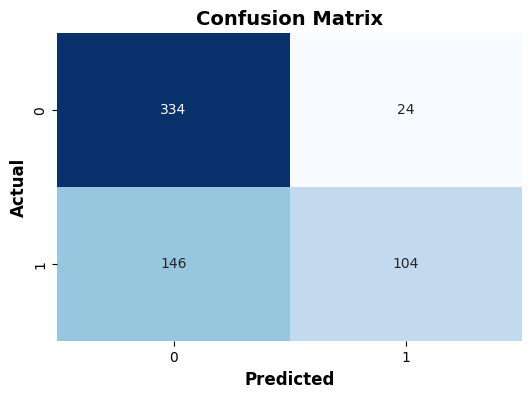

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)

plt.xlabel('Predicted', fontsize=12, fontweight='bold')
plt.ylabel('Actual', fontsize=12, fontweight='bold')
plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.show()